# ***Import all the needed libraries.***

In [ ]:
import nltk
import re
import copy
import random
import collections
import time
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from mlxtend.plotting import plot_learning_curves
from sklearn import svm
from sklearn.feature_selection import mutual_info_classif
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import learning_curve, ShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score, plot_confusion_matrix, auc

# ***Importing the dataset in .csv form from my Google drive account.***

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# ***Creation of the dataframe.***





In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/NLP_Project_2_Dataset/IMDB_Dataset.csv', encoding='latin', header=None)

In [ ]:
df.head(5)

,0,1
0,review,sentiment
1,One of the other reviewers has mentioned that ...,positive
2,A wonderful little production. <br /><br />The...,positive
3,I thought this was a wonderful way to spend ti...,positive
4,Basically there's a family where a little boy ...,negative


In [ ]:
df.columns = ['review', 'sentiment']  # Naming the df's columns
df.head(5)
df = df.drop(0)                       # Drop the first row of the df, as it contained some headers

In [ ]:
label_to_sentiment = {'negative': 0, 'positive': 1} # Map the negative labels to 0, and the positives to 1 for easier handling of the data

def label_decoder(label):
  return label_to_sentiment[label]

df.sentiment = df.sentiment.apply(lambda x: label_decoder(x)) # And apply the mapping!
df.head() # Let's see the changes

,review,sentiment
1,One of the other reviewers has mentioned that ...,1
2,A wonderful little production. <br /><br />The...,1
3,I thought this was a wonderful way to spend ti...,1
4,Basically there's a family where a little boy ...,0
5,"Petter Mattei's ""Love in the Time of Money"" is...",1


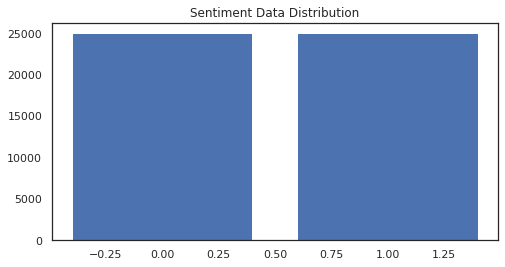

In [ ]:
# Calculate the 'sentiment' data distribution in our dataset
val_count = df.sentiment.value_counts()

# And plot it!
plt.figure(figsize=(8,4));
plt.bar(val_count.index, val_count.values);
plt.title("Sentiment Data Distribution");

In [ ]:
x = df['review'].tolist()     # Convert dataframe to list
y = df['sentiment'].to_list() # Same here...

In [ ]:
# --- Returns two lists. One containing the positive movie reviews and one that contains the negatives. ---

def seperate_positive_with_negative_texts(dataset, classes):
    positive_texts = []
    negative_texts = []

    for x in range(0, len(dataset)):
        if classes[x] == 0:
            positive_texts.append(dataset[x])
        else:
            negative_texts.append(dataset[x])

    return positive_texts, negative_texts

In [ ]:
# Download 3 needed packages
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# --- Preprocess the dataset ---

stemmer = WordNetLemmatizer() # Initialize stemmer in order to stem the words
tweets = []

for t in x:
    # Remove non-word (special) characters such as punctuation, numbers etc
    tweet = re.sub(r'\W', ' ', str(t))

    # Remove all single characters
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
      
    # Substitute multiple spaces with single space
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)

    # Convert to Lowercase
    tweet = tweet.lower()

    # Split the document based on whitespaces (--> List of words)
    tweet = tweet.split()
    
    # Lemmatization
    tweet = [stemmer.lemmatize(word) for word in tweet]

    # Reconstruct the document by joining the words on each whitespace
    tweet = ' '.join(tweet)

    # Append all documents into a list 'docs'
    tweets.append(tweet)

In [ ]:
# Let's see an overview of the filtered dataset. 

print("\nOriginal review text:\n{}".format(x[414]))       # First print the original form of a random review
print("\nFiltered review text:\n{}".format(tweets[414]))  # Then the filtered version after the text pre-processing loop
print("\nLabel:\n", y[414])                               # And finally the label of the movie review.


Original review text:
I feel dumber after watching the first 20 min,luckily i walked out and saved the rest of my brain, people should watch better films and take notes on why they are rated highly,not because of the budget of the film or the special effects, just simply good acting and getting simple things right,and MOst importantly--not being LAME--, but i guess this was produced for those Sheeple without taste and not a clue of what is ''A good Movie''don't be scared of rating films low,save your under-appreciated high scores for ''once in a life time movies''. Keep in mind that many use IMDb for trusted reviews and opinions,don't spoil the broth by sugarcoating turds Peace & love

Filtered review text:
i feel dumber after watching the first 20 min luckily walked out and saved the rest of my brain people should watch better film and take note on why they are rated highly not because of the budget of the film or the special effect just simply good acting and getting simple thing ri

# ***Split the dataset into train, dev, test subsets.***

In [ ]:
x_train, x_devtest, y_train, y_devtest = train_test_split(tweets, y, test_size=0.25, random_state=25431892)

In [ ]:
x_dev, x_test, y_dev, y_test = train_test_split(x_devtest, y_devtest, test_size=0.75, random_state=25431892)

In [ ]:
# Copy the train dataset for potential later use 
x_train_instances = copy.deepcopy(x_train)

# Split the training texts into positive and negative ones for later use (evaluation metrics)
X_positive, X_negative = seperate_positive_with_negative_texts(x_train, y_train)

In [ ]:
# Let's showcase some random movie_reviews from the three subsets
rand1 = random.randrange(len(x_train))
rand2 = random.randrange(len(x_dev))	
rand3 = random.randrange(len(x_test))	

print("Random train tweet:\n{}".format(x_train[rand1]))
print("Random train tweet label:\n{}".format(y_train[rand1]))
print("-------------------------------------------------------")
print("Random dev tweet:\n{}".format(x_dev[rand2]))
print("Random dev tweet label:\n{}".format(y_dev[rand2]))
print("-------------------------------------------------------")
print("Random test tweet:\n{}".format(x_test[rand3]))
print("Random test tweet label:\n{}".format(y_test[rand3]))

# And let's also take a look on the subsets' length
print("\nTrain data length: {}".format(len(x_train)))
print("Dev data length: {}".format(len(x_dev)))
print("Test data length: {}".format(len(x_test)))

Random train tweet:
if this is supposed to be portrayal of the american serial killer it come across a decidedly average br br journalist duchovny travel across country to california to document america most famous murderer unaware that one of his white trailer trash travelling companion pitt is serial killer himself br br rather predictable throughout this ha it moment of action and pitt and lewis portray their role well but d not bother to see it again
Random train tweet label:
1
-------------------------------------------------------
Random dev tweet:
i saw this film for the first time not too long on tcm essential series the eye of the beholder clichã wa never more apropos this beholder saw little of value in this one wa puzzled by the infinite attraction that lucy lauren bacall possessed granted m bacall wa beautiful woman but in this film her character come off more mousy than attractive would think men like mitch wayne and kyle hadley would more likely ignore lucy than fall into

# ***Feature Extraction***

***1. Boolean vector***

In [ ]:
# --- First feature extraction ---
# Boolean vector, i.e. a sparse vector of length equal to the different unigrams of the dataset, containing 1's and 0's.

vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), binary = True, stop_words = stopwords.words('english')) #define the vectorizer...

train_boolean_vector = vectorizer.fit_transform(x_train)  # Train the vectorizer on the train data
dev_boolean_vector = vectorizer.transform(x_dev)          # And apply the changes on the dev...
test_boolean_vector = vectorizer.transform(x_test)        # And the test data

vectorizer.get_feature_names_out()                        # Print the features...

# Initialize our vocabulary with 50 random boolean features
vocabulary = random.sample(vectorizer.get_feature_names(), 50)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Print the shapes
print(train_boolean_vector.shape)
print(dev_boolean_vector.shape)
print(test_boolean_vector.shape)

(37500, 82613)
(3125, 82613)
(9375, 82613)


***2. TF-IDF vector***

In [ ]:
# --- Second feature extraction --- 
# TF-IDF vector, containing the max_features = 8000 best unigrams/bigrams in terms of TF-ID values

# Use unigram & bi-gram TF-IDF features
tf_idf_vectorizer = TfidfVectorizer(
    ngram_range = (1, 2), 
    max_features = 8000,
    # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
    sublinear_tf = True, 
    stop_words = stopwords.words('english'))

# Fit Vectorizer on train data
# Transform on all data (train - test)
x_train_tfidf_vector = tf_idf_vectorizer.fit_transform(x_train)
x_dev_tfidf_vector = tf_idf_vectorizer.transform(x_dev)
x_test_tfidf_vector = tf_idf_vectorizer.transform(x_test)

print(tf_idf_vectorizer.get_feature_names())

['00', '000', '10', '10 10', '10 br', '10 minute', '10 star', '10 year', '100', '101', '11', '12', '12 year', '13', '13th', '14', '14 year', '15', '15 minute', '15 year', '16', '17', '18', '19', '1930', '1930s', '1933', '1939', '1940', '1940s', '1945', '1950', '1950s', '1955', '1959', '1960', '1960s', '1968', '1969', '1970', '1970s', '1971', '1972', '1973', '1974', '1977', '1978', '1979', '1980', '1980s', '1981', '1982', '1983', '1984', '1987', '1988', '1989', '1990', '1991', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19th', '19th century', '1st', '20', '20 minute', '20 year', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '20th', '20th century', '21', '21st', '21st century', '22', '23', '24', '25', '25 year', '28', '2nd', '30', '30 minute', '30 year', '3000', '35', '3rd', '40', '40 minute', '40 year', '45', '45 minute', '4th', '50', '60', '70', '75', '80', '90', '90 minute', '95', '99', 'aaron', 'abandon', 'abandoned', 'abc', 'ability', 'a

In [ ]:
# Let's observe the size transformation
print('Shape of training data after TF-IDF feature extraction: {}'.format(x_train_tfidf_vector.shape))
print('Shape of development data after TF-IDF feature extraction: {}'.format(x_dev_tfidf_vector.shape))
print('Shape of test data after TF-IDF feature extraction: {}\n'.format(x_test_tfidf_vector.shape))

print(x_test_tfidf_vector[0, :])  # Sparce matrix --> Saves only the cells which are not zero

Shape of training data after TF-IDF feature extraction: (37500, 8000)
Shape of development data after TF-IDF feature extraction: (3125, 8000)
Shape of test data after TF-IDF feature extraction: (9375, 8000)

  (0, 7981)	0.14299878680414088
  (0, 7972)	0.13899542444656954
  (0, 7749)	0.0465393977747522
  (0, 7710)	0.06082984148618855
  (0, 7432)	0.1022620015919835
  (0, 7421)	0.14739670865016605
  (0, 7406)	0.07815401808422866
  (0, 7318)	0.14588188002271082
  (0, 7084)	0.10197362710790873
  (0, 7018)	0.05098171797880027
  (0, 6963)	0.12537937424008672
  (0, 6962)	0.10858602872378668
  (0, 6924)	0.08752484869393919
  (0, 6912)	0.0575048548597583
  (0, 6779)	0.08150352235341181
  (0, 6766)	0.1005393847562052
  (0, 6745)	0.12569772492677372
  (0, 6729)	0.09578947228594596
  (0, 6635)	0.13899542444656954
  (0, 6580)	0.14351412529222837
  (0, 6547)	0.078416539164538
  (0, 6525)	0.1003028144407281
  (0, 6463)	0.13105538727318453
  (0, 6185)	0.06881518960749769
  (0, 6138)	0.04906016737524087

# ***Dimensionality Reduction***

***1. Truncated SVD***

In [ ]:
# Dimensionality Reduction using SVD
# Using n_components = 2 , mostly in order to be able to plot it in the two-dimensional space...
svd = TruncatedSVD(n_components=2, random_state=1005)
x_train_trunc_SVD = svd.fit_transform(x_train_tfidf_vector)
x_dev_trunc_SVD = svd.transform(x_dev_tfidf_vector)
x_test_trunc_SVD = svd.transform(x_test_tfidf_vector)

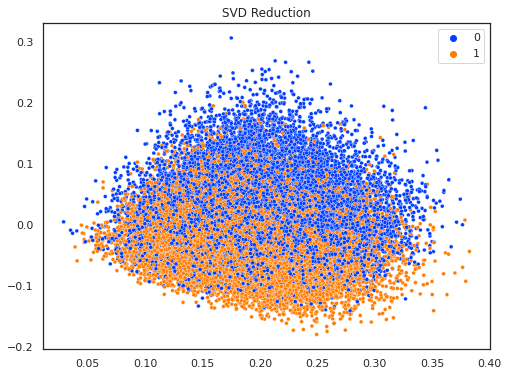

In [ ]:
# Print the SVD-ed values in the two-dimensional space
sns.set(rc={'figure.figsize':(8, 6)})     # Define the figure size
palette = sns.color_palette("bright", 2)  # And the figure color

# Plot the points
sns.set_theme(style='white')
sns.scatterplot(x=x_train_trunc_SVD[:,0], y=x_train_trunc_SVD[:,1], hue=y_train, legend='full', palette=palette, s=15).set(title='SVD Reduction');

# ***Feature Selection***

In [ ]:
# perform feature selection
# i.e. keep the best 3000 features out of the 8000 features that we already have extracted (tf-idf vector)
# we select these 3000 features in terms of the mutual information metric. It is pretty similar to the Information Gain metric.

# Number of features to keep
k = 3000

# Convert sparse matrix to np.array
x_train_tfidf_array = x_train_tfidf_vector.toarray()  

# The function relies on nonparametric methods 
# based on entropy estimation from k-nearest neighbors distances
mutual_information = mutual_info_classif(x_train_tfidf_array, y_train, n_neighbors=3, 
                                         discrete_features=True,
                                         random_state=1026)

# Indexes of the feature columns
indexes = np.arange(len(mutual_information))

print("Indexes: ", indexes)

# Sort by mutual information values --> (value, idx)
sorted_indexes = sorted(zip(mutual_information, indexes), reverse=True)
print('Sorted indexes: {}'.format(sorted_indexes[:4]))

# keep the indexes of the best k features
best_idxs = [idx for val, idx in sorted_indexes[:k]]
print('Best indexes: {}\n'.format(best_idxs[:4]))

# Keep only the colums of the best features
x_train_best_tfidf = x_train_tfidf_array[:, best_idxs]
x_dev_best_tfidf = x_dev_tfidf_vector[:, best_idxs]
x_test_best_tfidf = x_test_tfidf_vector[:, best_idxs]

print('Shape of training data: {} --> {}'.format(x_train_tfidf_array.shape, x_train_best_tfidf.shape))
print('Shape of test data: {} --> {}\n'.format(x_test_tfidf_vector.shape, x_test_best_tfidf.shape))

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warni

Indexes:  [   0    1    2 ... 7997 7998 7999]
Sorted indexes: [(0.4525650297303938, 4629), (0.4465791118307665, 7506), (0.40670310622412315, 871), (0.4066661139738368, 888)]
Best indexes: [4629, 7506, 871, 888]

Shape of training data: (37500, 8000) --> (37500, 3000)
Shape of test data: (9375, 8000) --> (9375, 3000)



# ***Centroid of Pre-Trained Word Embeddings***




We do not suggest to run the following code as it is too time-consuming and also has a heavy impact on the allocated RAM memory that the colab offers. We managed to run the code twice during the two weeks of working on the assignment. The results were good, but not great. They were, of course, beating the dummy classifier by far, but they were not close to the results given by the Logistic Regression or the Naive Bayes classifier.

In [ ]:
# import of pre-trained word embeddings from nlp.stanford.edu
"""
import urllib.request

urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')
!unzip "/content/glove.6B.zip" -d "/content/"
"""

'\nimport urllib.request\n\nurllib.request.urlretrieve(\'https://nlp.stanford.edu/data/glove.6B.zip\',\'glove.6B.zip\')\n!unzip "/content/glove.6B.zip" -d "/content/"\n'

In [ ]:
"""
# emmbed dict contains the 100-dimensional pre-trained word embeddings of many english words
emmbed_dict = {}
with open('/content/glove.6B.100d.txt','r') as f: #open the file
  for line in f: #reading each line of the file
    values = line.split() #split in words
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector #assign the words


centroids = np.empty([len(x_train_instances), 100]) #let's now build the centroids
for tweet in x_train_instances: # for each document
  sumW = 0
  w = []
  position = x_train_instances.index(tweet) # retrieve the doc's position in the training dataset list
  tweet = tweet.split()
  d = len(tweet)
  
  for i in range(d): # looping through the doc's words
    wi = [] # initializing weight vectors for each word
    wj = 0 # also a weight variable
    tf_denominator = 0 # and the denominator summing variable
    for j in range(d): #looping through each doc's word again, calculating the numerator value
      tf_numerator = (tweet.count(tweet[j]) / len(tweet))
      if tweet[j] in emmbed_dict.keys(): 
        wj += emmbed_dict[tweet[j]] * tf_numerator    # assigning the word_embedding * numerator_obtained_value to the weight variable
    for jj in range(d):   # loop in order to calculate the denominator value 
      tf_denominator += (tweet.count(tweet[jj]) / len(tweet))
  
    wi.append(wj / tf_denominator)  # append the calculated value to the weight vector
  for w in range(len(wi)):
    wi[w] = np.array(wi[w])
    sumW += wi[w]     # calculating the final centroid values...

  
  centroids[position] = (sumW / d)     # and assigning them to the corresponding vector

    """

"\nemmbed_dict = {}\nwith open('/content/glove.6B.100d.txt','r') as f:\n  for line in f:\n    values = line.split()\n    word = values[0]\n    vector = np.asarray(values[1:],'float32')\n    emmbed_dict[word]=vector\n    "

# ***Metrics Tables Creation of Data Structures & Functions***


In [ ]:
# --- Ccalculates the F1-metric for each distinct class (in our case: positive, negative). ---

def calculate_f1_score_per_class(precision, recall):
    if precision + recall == 0:
        return 0
    else:
        return (2 * precision * recall) / (precision + recall)

In [ ]:
# --- Calculates the AUC scores given some data, their true labels and the estimator to be used. ---

def calculate_auc_scores(X, Y, clf):
    threshold = 0.0
    y_predictions = []

    for i in range(0, 12):
        # Numpy array containing predictions for the specified threshold
        y_pred = (clf.predict_proba(X)[:,1] >= threshold).astype(int)
        y_predictions.append(y_pred.tolist())
        # Increase the threshold by 0.1
        threshold += 0.1
  
    precision_0 = []
    recall_0 = []
    precision_1 = []
    recall_1 = []
    for i in range(0, 12):
        pr = precision_score(Y, y_predictions[i], average=None)
        rec = recall_score(Y, y_predictions[i], average=None)

        pr_0 = pr[0]
        pr_1 = pr[1]
        rec_0 = rec[0]
        rec_1 = rec[1]

        precision_0.append(pr_0)
        recall_0.append(rec_0)
        precision_1.append(pr_1)
        recall_1.append(rec_1)

    auc_precision_recall_0 = auc(np.array(recall_0), np.array(precision_0))
    auc_precision_recall_1 = auc(np.array(recall_1), np.array(precision_1))
    
    return auc_precision_recall_0, auc_precision_recall_1

# ***Classifiers***


***Baseline -  Dummy Classifier***

Train accuracy: 50.12%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Dev accuracy: 49.79%
Test accuracy: 49.58%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr


Confusion Matrix for test data:


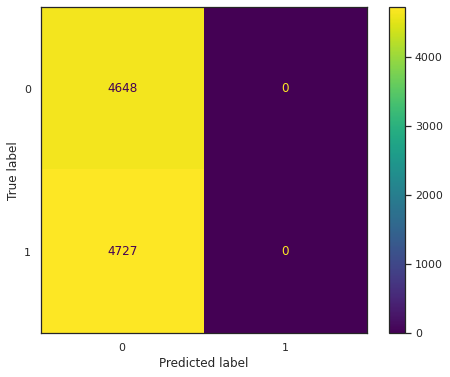

In [ ]:
# --------------------- (1) Baseline: Dummy Classifier ---------------------

# Train the dummy classifier who always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
dummy_start_time = time.time()
baseline.fit(x_train_tfidf_vector, y_train)
dummy_end_time = time.time()

# Evaluate - Train set
predictions_train = baseline.predict(x_train_tfidf_vector)
score_dummy_train = accuracy_score(y_train, predictions_train)
print("Train accuracy: {:.2f}%".format(score_dummy_train*100))

pr_train = precision_score(y_train, predictions_train, average=None)
rec_train = recall_score(y_train, predictions_train, average=None)

precision_dummy_train_0 = pr_train[0]
precision_dummy_train_1 = pr_train[1]
recall_dummy_train_0 = rec_train[0]
recall_dummy_train_1 = rec_train[1]
f1_dummy_train_0 = calculate_f1_score_per_class(precision_dummy_train_0, recall_dummy_train_0)
f1_dummy_train_1 = calculate_f1_score_per_class(precision_dummy_train_1, recall_dummy_train_1)
auc_dummy_train_0, auc_dummy_train_1 = calculate_auc_scores(x_train_tfidf_vector, y_train, baseline)

# Evaluate - Development set
predictions_dev = baseline.predict(x_dev_tfidf_vector)
score_dummy_dev = accuracy_score(y_dev, predictions_dev)
print("Dev accuracy: {:.2f}%".format(score_dummy_dev*100))

pr_dev = precision_score(y_dev, predictions_dev, average=None)
rec_dev = recall_score(y_dev, predictions_dev, average=None)

precision_dummy_dev_0 = pr_dev[0]
precision_dummy_dev_1 = pr_dev[1]
recall_dummy_dev_0 = rec_dev[0]
recall_dummy_dev_1 = rec_dev[1]
f1_dummy_dev_0 = calculate_f1_score_per_class(precision_dummy_dev_0, recall_dummy_dev_0)
f1_dummy_dev_1 = calculate_f1_score_per_class(precision_dummy_dev_1, recall_dummy_dev_1)
auc_dummy_dev_0, auc_dummy_dev_1 = calculate_auc_scores(x_dev_tfidf_vector, y_dev, baseline)

# Evaluate - Test set
predictions_test = baseline.predict(x_test_tfidf_vector)
score_dummy_test = accuracy_score(y_test, predictions_test)
print("Test accuracy: {:.2f}%".format(score_dummy_test*100))

pr_test = precision_score(y_test, predictions_test, average=None)
rec_test = recall_score(y_test, predictions_test, average=None)

precision_dummy_test_0 = pr_test[0]
precision_dummy_test_1 = pr_test[1]
recall_dummy_test_0 = rec_test[0]
recall_dummy_test_1 = rec_test[1]
f1_dummy_test_0 = calculate_f1_score_per_class(precision_dummy_test_0, recall_dummy_test_0)
f1_dummy_test_1 = calculate_f1_score_per_class(precision_dummy_test_1, recall_dummy_test_1)
auc_dummy_test_0, auc_dummy_test_1 = calculate_auc_scores(x_test_tfidf_vector, y_test, baseline)

# Plot the confussion matrix for the test data
print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=baseline, X=x_test_tfidf_vector, y_true=y_test, values_format = '.0f')

***Logistic Regression***

Train f1-score: 92.45%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Dev f1-score: 89.66%
Test f1-score: 90.27%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix for test data:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


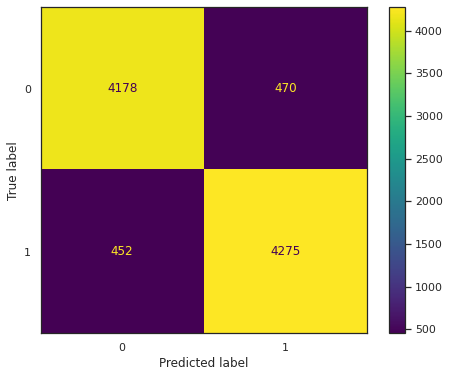

In [ ]:
# --------------------- (2) Logistic Regression ---------------------

# Train
clf = LogisticRegression(solver="liblinear")
start_time_lr = time.time()
clf.fit(x_train_tfidf_vector, y_train)
end_time_lr = time.time()

# Evaluate - Train set
predictions_train = clf.predict(x_train_tfidf_vector)
score_lr_train = f1_score(y_train, predictions_train)
print("Train f1-score: {:.2f}%".format(score_lr_train*100))

pr_train = precision_score(y_train, predictions_train, average=None)
rec_train = recall_score(y_train, predictions_train, average=None)

precision_lr_train_0 = pr_train[0]
precision_lr_train_1 = pr_train[1]
recall_lr_train_0 = rec_train[0]
recall_lr_train_1 = rec_train[1]
f1_lr_train_0 = calculate_f1_score_per_class(precision_lr_train_0, recall_lr_train_0)
f1_lr_train_1 = calculate_f1_score_per_class(precision_lr_train_1, recall_lr_train_1)
auc_lr_train_0, auc_lr_train_1 = calculate_auc_scores(x_train_tfidf_vector, y_train, clf)

# Evaluate - Development set
predictions_dev = clf.predict(x_dev_tfidf_vector)
score_lr_dev = f1_score(y_dev, predictions_dev)
print("Dev f1-score: {:.2f}%".format(score_lr_dev*100))

pr_dev = precision_score(y_dev, predictions_dev, average=None)
rec_dev = recall_score(y_dev, predictions_dev, average=None)

precision_lr_dev_0 = pr_dev[0]
precision_lr_dev_1 = pr_dev[1]
recall_lr_dev_0 = rec_dev[0]
recall_lr_dev_1 = rec_dev[1]
f1_lr_dev_0 = calculate_f1_score_per_class(precision_lr_dev_0, recall_lr_dev_0)
f1_lr_dev_1 = calculate_f1_score_per_class(precision_lr_dev_1, recall_lr_dev_1)
auc_lr_dev_0, auc_lr_dev_1 = calculate_auc_scores(x_dev_tfidf_vector, y_dev, clf)

# Evaluate - Test set
predictions_test = clf.predict(x_test_tfidf_vector)
score_lr_test = f1_score(y_test, predictions_test)
print("Test f1-score: {:.2f}%".format(score_lr_test*100))

pr_test = precision_score(y_test, predictions_test, average=None)
rec_test = recall_score(y_test, predictions_test, average=None)

precision_lr_test_0 = pr_test[0]
precision_lr_test_1 = pr_test[1]
recall_lr_test_0 = rec_test[0]
recall_lr_test_1 = rec_test[1]
f1_lr_test_0 = calculate_f1_score_per_class(precision_lr_test_0, recall_lr_test_0)
f1_lr_test_1 = calculate_f1_score_per_class(precision_lr_test_1, recall_lr_test_1)
auc_lr_test_0, auc_lr_test_1 = calculate_auc_scores(x_test_tfidf_vector, y_test, clf)

# Plot the confussion matrix for the test data
print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf, X=x_test_tfidf_vector, y_true=y_test, values_format = '.0f')

***Naive Bayes***


Train f1-score: 87.67%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Dev f1-score: 86.77%
Test f1-score: 87.13%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix for test data:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


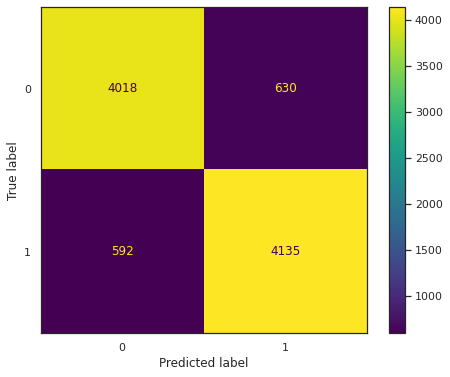

In [ ]:
# --------------------- (3) Naive Bayes ---------------------

# Train
clf = MultinomialNB()
start_time_nb = time.time()
clf.fit(x_train_tfidf_vector, y_train)
end_time_nb = time.time()

# Evaluate - Train set
predictions_train = clf.predict(x_train_tfidf_vector)
score_nb_train = f1_score(y_train, predictions_train)
print("Train f1-score: {:.2f}%".format(score_nb_train*100))

pr_train = precision_score(y_train, predictions_train, average=None)
rec_train = recall_score(y_train, predictions_train, average=None)

precision_nb_train_0 = pr_train[0]
precision_nb_train_1 = pr_train[1]
recall_nb_train_0 = rec_train[0]
recall_nb_train_1 = rec_train[1]
f1_nb_train_0 = calculate_f1_score_per_class(precision_nb_train_0, recall_nb_train_0)
f1_nb_train_1 = calculate_f1_score_per_class(precision_nb_train_1, recall_nb_train_1)
auc_nb_train_0, auc_nb_train_1 = calculate_auc_scores(x_train_tfidf_vector, y_train, clf)

# Evaluate - Development set
predictions_dev = clf.predict(x_dev_tfidf_vector)
score_nb_dev = f1_score(y_dev, predictions_dev)
print("Dev f1-score: {:.2f}%".format(score_nb_dev*100))

pr_dev = precision_score(y_dev, predictions_dev, average=None)
rec_dev = recall_score(y_dev, predictions_dev, average=None)

precision_nb_dev_0 = pr_dev[0]
precision_nb_dev_1 = pr_dev[1]
recall_nb_dev_0 = rec_dev[0]
recall_nb_dev_1 = rec_dev[1]
f1_nb_dev_0 = calculate_f1_score_per_class(precision_nb_dev_0, recall_nb_dev_0)
f1_nb_dev_1 = calculate_f1_score_per_class(precision_nb_dev_1, recall_nb_dev_1)
auc_nb_dev_0, auc_nb_dev_1 = calculate_auc_scores(x_dev_tfidf_vector, y_dev, clf)

# Evaluate - Test set
predictions_test = clf.predict(x_test_tfidf_vector)
score_nb_test = f1_score(y_test, predictions_test)
print("Test f1-score: {:.2f}%".format(score_nb_test*100))

pr_test = precision_score(y_test, predictions_test, average=None)
rec_test = recall_score(y_test, predictions_test, average=None)

precision_nb_test_0 = pr_test[0]
precision_nb_test_1 = pr_test[1]
recall_nb_test_0 = rec_test[0]
recall_nb_test_1 = rec_test[1]
f1_nb_test_0 = calculate_f1_score_per_class(precision_nb_test_0, recall_nb_test_0)
f1_nb_test_1 = calculate_f1_score_per_class(precision_nb_test_1, recall_nb_test_1)
auc_nb_test_0, auc_nb_test_1 = calculate_auc_scores(x_test_tfidf_vector, y_test, clf)

# Plot the confussion matrix for the test data
print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf, X=x_test_tfidf_vector, y_true=y_test, values_format = '.0f')

***Custom Multinomial Naive Bayes***




In [ ]:
# --- Custom multinomial Naive Bayes implementation. ---

def custom_multinomial_naive_bayes_classifier(positive_texts, negative_texts, text, vocab, alpha):
    # First, find out the total number of texts belonging to the positive, and the negative classes
    num_positive_classes = len(positive_texts)
    num_negative_classes = len(negative_texts)

    # Furthermore, calculate some important stuff needed below
    V = len(vocab)
    number_of_positive_tokens = len(positive_texts)
    number_of_negative_tokens = len(negative_texts)

    # Then, calculate their probabilities
    p_positive = num_positive_classes/(len(positive_texts) + len(negative_texts))
    p_negative = num_negative_classes/(len(positive_texts) + len(negative_texts))

    # Create counter instances for both of positive and negative classes
    positive_counters = collections.Counter(positive_texts)
    negative_counters = collections.Counter(negative_texts)

    # --- Calculate the positive probability of the classifier ---
    positive_probability_mul = 1
    for word in text:
        if word in vocab:
            # Calculate the: P(word|+) = count(word, +) / count(+) + a*|V|
            positive_probability_mul *= (positive_counters[word] + alpha) / (number_of_positive_tokens + alpha*V)
    positive_probability_mul *= p_positive

    # --- Calculate the negative probability of the classifier ---
    negative_probability_mul = 1
    for word in text:
        if word in vocab:
            # Calculate the: P(word|-) = count(word, -) / count(-) + a*|V|
            negative_probability_mul *= (negative_counters[word] + alpha) / (number_of_negative_tokens + alpha*V)
    negative_probability_mul *= p_negative

    # Finally, compare and return the predicted class
    if positive_probability_mul >= negative_probability_mul:
        return 0
    else:
        return 1

In [ ]:
# --------------------- (4) Custom Multinomial Naive Bayes ---------------------

# Development
dev_predicted_values_mul_naive_bayes = []
for x in range(0, len(x_dev)):
  predicted_value = custom_multinomial_naive_bayes_classifier(X_positive, X_negative, x_dev[x], vocabulary, 0.01)
  dev_predicted_values_mul_naive_bayes.append(predicted_value)
score_mul_naive_bayes_dev = f1_score(y_dev, dev_predicted_values_mul_naive_bayes)

pr_dev = precision_score(y_dev, dev_predicted_values_mul_naive_bayes, average=None)
rec_dev = recall_score(y_dev, dev_predicted_values_mul_naive_bayes, average=None)

precision_cus_nb_dev_0 = pr_dev[0]
precision_cus_nb_dev_1 = pr_dev[1]
recall_cus_nb_dev_0 = rec_dev[0]
recall_cus_nb_dev_1 = rec_dev[1]
f1_cus_nb_dev_0 = calculate_f1_score_per_class(precision_cus_nb_dev_0, recall_cus_nb_dev_0)
f1_cus_nb_dev_1 = calculate_f1_score_per_class(precision_cus_nb_dev_1, recall_cus_nb_dev_1)

# Test
test_predicted_values_mul_naive_bayes = []
for x in range(0, len(x_test)):
  predicted_value = custom_multinomial_naive_bayes_classifier(X_positive, X_negative, x_test[x], vocabulary, 0.01)
  test_predicted_values_mul_naive_bayes.append(predicted_value)
score_mul_naive_bayes_test = f1_score(y_test, test_predicted_values_mul_naive_bayes)

pr_test = precision_score(y_test, test_predicted_values_mul_naive_bayes, average=None)
rec_test = recall_score(y_test, test_predicted_values_mul_naive_bayes, average=None)

precision_cus_nb_test_0 = pr_test[0]
precision_cus_nb_test_1 = pr_test[1]
recall_cus_nb_test_0 = rec_test[0]
recall_cus_nb_test_1 = rec_test[1]
f1_cus_nb_test_0 = calculate_f1_score_per_class(precision_cus_nb_test_0, recall_cus_nb_test_0)
f1_cus_nb_test_1 = calculate_f1_score_per_class(precision_cus_nb_test_1, recall_cus_nb_test_1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***KNN***



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr


Confusion Matrix for test data:


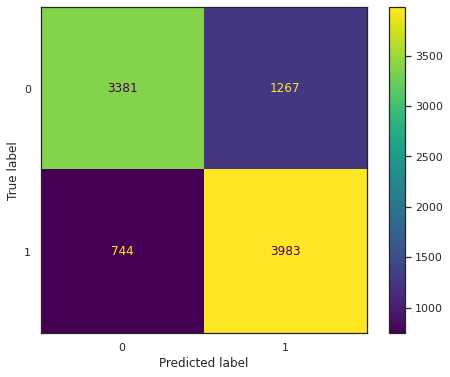

In [ ]:
# --------------------- (5) KNN ---------------------

# Train
clf = KNeighborsClassifier(n_neighbors=3)
start_time_knn = time.time()
clf.fit(x_train_tfidf_vector, y_train)
end_time_knn = time.time()

# Evaluate - Train set
predictions_train = clf.predict(x_train_tfidf_vector)
score_knn_train = f1_score(y_train, predictions_train)

pr_train = precision_score(y_train, predictions_train, average=None)
rec_train = recall_score(y_train, predictions_train, average=None)

precision_knn_train_0 = pr_train[0]
precision_knn_train_1 = pr_train[1]
recall_knn_train_0 = rec_train[0]
recall_knn_train_1 = rec_train[1]
f1_knn_train_0 = calculate_f1_score_per_class(precision_knn_train_0, recall_knn_train_0)
f1_knn_train_1 = calculate_f1_score_per_class(precision_knn_train_1, recall_knn_train_1)

# Evaluate - Development set
predictions_dev = clf.predict(x_dev_tfidf_vector)
score_knn_dev = f1_score(y_dev, predictions_dev)

pr_dev = precision_score(y_dev, predictions_dev, average=None)
rec_dev = recall_score(y_dev, predictions_dev, average=None)

precision_knn_dev_0 = pr_dev[0]
precision_knn_dev_1 = pr_dev[1]
recall_knn_dev_0 = rec_dev[0]
recall_knn_dev_1 = rec_dev[1]
f1_knn_dev_0 = calculate_f1_score_per_class(precision_knn_dev_0, recall_knn_dev_0)
f1_knn_dev_1 = calculate_f1_score_per_class(precision_knn_dev_1, recall_knn_dev_1)
auc_knn_dev_0, auc_knn_dev_1 = calculate_auc_scores(x_dev_tfidf_vector, y_dev, clf)

# Evaluate - Test set
predictions_test = clf.predict(x_test_tfidf_vector)
score_knn_test = f1_score(y_test, predictions_test)

pr_test = precision_score(y_test, predictions_test, average=None)
rec_test = recall_score(y_test, predictions_test, average=None)

precision_knn_test_0 = pr_test[0]
precision_knn_test_1 = pr_test[1]
recall_knn_test_0 = rec_test[0]
recall_knn_test_1 = rec_test[1]
f1_knn_test_0 = calculate_f1_score_per_class(precision_knn_test_0, recall_knn_test_0)
f1_knn_test_1 = calculate_f1_score_per_class(precision_knn_test_1, recall_knn_test_1)
auc_knn_test_0, auc_knn_test_1 = calculate_auc_scores(x_test_tfidf_vector, y_test, clf)

# Plot the confussion matrix for the test data
print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf, X=x_test_tfidf_vector, y_true=y_test, values_format = '.0f')

# ***Evaluation - Metrics***

***F1 score & training time for each classifier***

In [ ]:
# Calculate the training times for each method
dummy_train_time = dummy_end_time - dummy_start_time
nb_train_time = end_time_nb - start_time_nb
lr_train_time = end_time_lr - start_time_lr
knn_train_time = end_time_knn - start_time_knn

# Data
data = {'F1 score (Train)': ["{:.2f}".format(score_dummy_train*100) + "%", 'n/a', "{:.2f}".format(score_nb_train*100) + "%", "{:.2f}".format(score_lr_train*100) + "%", "{:.2f}".format(score_knn_train*100) + "%"], 
        'F1 score (Dev)': ["{:.2f}".format(score_dummy_dev*100) + "%", "{:.2f}".format(score_mul_naive_bayes_dev*100) + "%","{:.2f}".format(score_nb_dev*100) + "%", "{:.2f}".format(score_lr_dev*100) + "%", "{:.2f}".format(score_knn_dev*100) + "%"], 
        'F1 score (Test)': ["{:.2f}".format(score_dummy_test*100) + "%", "{:.2f}".format(score_mul_naive_bayes_test*100) + "%", "{:.2f}".format(score_nb_test*100) + "%", "{:.2f}".format(score_lr_test*100) + "%", "{:.2f}".format(score_knn_test*100) + "%"], 
        'Training time': ["{:.4f}".format(dummy_train_time) + ' sec.', 'n/a', "{:.4f}".format(nb_train_time) + ' sec.', "{:.4f}".format(lr_train_time) + ' sec.', "{:.4f}".format(knn_train_time) + ' sec.']
        }

# Create the dataframe
results_df = pd.DataFrame(data, index=['Dummy Classifier', 
                               'Custom Multinomial Naive Bayes',
                               'Naive Bayes', 
                               'Logistic Regression', 
                               'KNN'])

In [ ]:
results_df

,F1 score (Train),F1 score (Dev),F1 score (Test),Training time
Dummy Classifier,50.12%,49.79%,49.58%,0.0053 sec.
Custom Multinomial Naive Bayes,n/a,0.00%,0.00%,n/a
Naive Bayes,87.67%,86.77%,87.13%,0.0276 sec.
Logistic Regression,92.45%,89.66%,90.27%,0.6890 sec.
KNN,89.79%,80.69%,79.84%,0.0230 sec.


***Precision, recall, F1 score, Precision-Recall AUC score per class for each classifier on training data***

In [ ]:
# Insert the data
train_classifier_data = {
    'Precision (class 0)': [precision_dummy_train_0, 'n/a', precision_nb_train_0, precision_lr_train_0, precision_knn_train_0],
    'Recall (class 0)': [recall_dummy_train_0, 'n/a', recall_nb_train_0, recall_lr_train_0, recall_knn_train_0],
    'F1 (class 0)': [f1_dummy_train_0, 'n/a', f1_nb_train_0, f1_lr_train_0, f1_knn_train_0],
    'AUC (class 0)': [auc_dummy_train_0, 'n/a', auc_nb_train_0, auc_lr_train_0, '-'],
    'Precision (class 1)': [precision_dummy_train_1, 'n/a', precision_nb_train_1, precision_lr_train_1, precision_knn_train_1],
    'Recall (class 1)': [recall_dummy_train_1, 'n/a', recall_nb_train_1, recall_lr_train_1, recall_knn_train_1],
    'F1 (class 1)': [f1_dummy_train_1, 'n/a', f1_nb_train_1, f1_lr_train_1, f1_knn_train_1],
    'AUC (class 1)': [auc_dummy_train_1, 'n/a', auc_nb_train_1, auc_lr_train_1, '-']
}

# Create the dataframe
classifiers_results_df_train = pd.DataFrame(train_classifier_data, index=['Dummy Classifier',
                                                                    'Custom Multinomial Naive Bayes',
                                                                    'Naive Bayes',
                                                                    'Logistic Regression',
                                                                    'KNN'])

In [ ]:
classifiers_results_df_train 

,Precision (class 0),Recall (class 0),F1 (class 0),AUC (class 0),Precision (class 1),Recall (class 1),F1 (class 1),AUC (class 1)
Dummy Classifier,0.501227,1.0,0.667756,0.250613,0.0,0.0,0,0.249387
Custom Multinomial Naive Bayes,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
Naive Bayes,0.886166,0.861886,0.873857,0.82829,0.864925,0.88874,0.876671,0.876184
Logistic Regression,0.93149,0.91578,0.923568,0.741296,0.916776,0.932314,0.92448,0.763407
KNN,0.927575,0.85582,0.890254,-,0.865562,0.932849,0.897947,-


***Precision, recall, F1 score, Precision-Recall AUC score per class for each classifier on development data***

In [ ]:
# Insert the data
dev_classifier_data = {
    'Precision (class 0)': [precision_dummy_dev_0, precision_cus_nb_dev_0, precision_nb_dev_0, precision_lr_dev_0, precision_knn_dev_0],
    'Recall (class 0)': [recall_dummy_dev_0, recall_cus_nb_dev_0, recall_nb_dev_0, recall_lr_dev_0, recall_knn_dev_0],
    'F1 (class 0)': [f1_dummy_dev_0, f1_cus_nb_dev_0, f1_nb_dev_0, f1_lr_dev_0, f1_knn_dev_0],
    'AUC (class 0)': [auc_dummy_dev_0, 'n/a', auc_nb_dev_0, auc_lr_dev_0, auc_knn_dev_0],
    'Precision (class 1)': [precision_dummy_dev_1, precision_cus_nb_dev_1, precision_nb_dev_1, precision_lr_dev_1, precision_knn_dev_1],
    'Recall (class 1)': [recall_dummy_dev_1, recall_cus_nb_dev_1, recall_nb_dev_1, recall_lr_dev_1, recall_knn_dev_1],
    'F1 (class 1)': [f1_dummy_dev_1, f1_cus_nb_dev_1, f1_nb_dev_1, f1_lr_dev_1, f1_knn_dev_1],
    'AUC (class 1)': [auc_dummy_dev_1, 'n/a', auc_nb_dev_1, auc_lr_dev_1, auc_knn_dev_1]
}

# Create the dataframe
classifiers_results_df_dev = pd.DataFrame(dev_classifier_data, index=['Dummy Classifier',
                                                                    'Custom Multinomial Naive Bayes',
                                                                    'Naive Bayes',
                                                                    'Logistic Regression',
                                                                    'KNN'])

In [ ]:
classifiers_results_df_dev 

,Precision (class 0),Recall (class 0),F1 (class 0),AUC (class 0),Precision (class 1),Recall (class 1),F1 (class 1),AUC (class 1)
Dummy Classifier,0.497920,1.000000,0.664815,0.24896,0.000000,0.000000,0.000000,0.25104
Custom Multinomial Naive Bayes,0.497920,1.000000,0.664815,n/a,0.000000,0.000000,0.000000,n/a
Naive Bayes,0.869565,0.861183,0.865354,0.824555,0.863636,0.871893,0.867745,0.877551
Logistic Regression,0.903417,0.883676,0.893437,0.722027,0.887087,0.906310,0.896595,0.745489
KNN,0.838421,0.723650,0.776820,0.662789,0.758698,0.861695,0.806923,0.58448


***Precision, recall, F1 score, Precision-Recall AUC score per class for each classifier on test data***

In [ ]:
# Insert the data
test_classifier_data = {
    'Precision (class 0)': [precision_dummy_test_0, precision_cus_nb_test_0, precision_nb_test_0, precision_lr_test_0, precision_knn_test_0],
    'Recall (class 0)': [recall_dummy_test_0, recall_cus_nb_test_0, recall_nb_test_0, recall_lr_test_0, recall_knn_test_0],
    'F1 (class 0)': [f1_dummy_test_0, f1_cus_nb_test_0, f1_nb_test_0, f1_lr_test_0, f1_knn_test_0],
    'AUC (class 0)': [auc_dummy_test_0, 'n/a', auc_nb_test_0, auc_lr_test_0, auc_knn_test_0],
    'Precision (class 1)': [precision_dummy_test_1, precision_cus_nb_test_1, precision_nb_test_1, precision_lr_test_1, precision_knn_test_1],
    'Recall (class 1)': [recall_dummy_test_1, recall_cus_nb_test_1, recall_nb_test_1, recall_lr_test_1, recall_knn_test_1],
    'F1 (class 1)': [f1_dummy_test_1, f1_cus_nb_test_1, f1_nb_test_1, f1_lr_test_1, f1_knn_test_1],
    'AUC (class 1)': [auc_dummy_test_1, 'n/a', auc_nb_test_1, auc_lr_test_1, auc_knn_test_1]
}

# Create the dataframe
classifiers_results_df_test = pd.DataFrame(test_classifier_data, index=['Dummy Classifier',
                                                                    'Custom Multinomial Naive Bayes',
                                                                    'Naive Bayes',
                                                                    'Logistic Regression',
                                                                    'KNN'])

In [ ]:
classifiers_results_df_test 

,Precision (class 0),Recall (class 0),F1 (class 0),AUC (class 0),Precision (class 1),Recall (class 1),F1 (class 1),AUC (class 1)
Dummy Classifier,0.495787,1.000000,0.662911,0.247893,0.000000,0.000000,0.000000,0.252107
Custom Multinomial Naive Bayes,0.495787,1.000000,0.662911,n/a,0.000000,0.000000,0.000000,n/a
Naive Bayes,0.871584,0.864458,0.868006,0.824312,0.867786,0.874762,0.871260,0.880885
Logistic Regression,0.902376,0.898881,0.900625,0.72902,0.900948,0.904379,0.902660,0.758851
KNN,0.819636,0.727410,0.770774,0.652998,0.758667,0.842606,0.798436,0.580948


***Macro-averaged precision, recall, F1 score, Precision-Recall AUC score for each classifier on training data***

In [ ]:
# Calculate the macro-averaged metrics for the train subset
macro_averaged_precision_dummy_train = (precision_dummy_train_0 + precision_dummy_train_1) / 2
macro_averaged_precision_nb_train = (precision_nb_train_0 + precision_nb_train_1) / 2
macro_averaged_precision_lr_train = (precision_lr_train_0 + precision_lr_train_1) / 2
macro_averaged_precision_knn_train = (precision_knn_train_0 + precision_knn_train_1) / 2

macro_averaged_recall_dummy_train = (recall_dummy_train_0 + recall_dummy_train_1) / 2
macro_averaged_recall_nb_train = (recall_nb_train_0 + recall_nb_train_1) / 2
macro_averaged_recall_lr_train = (recall_lr_train_0 + recall_lr_train_1) / 2
macro_averaged_recall_knn_train = (recall_knn_train_0 + recall_knn_train_1) / 2

macro_averaged_f1_dummy_train = (f1_dummy_train_0 + f1_dummy_train_1) / 2
macro_averaged_f1_nb_train = (f1_nb_train_0 + f1_nb_train_1) / 2
macro_averaged_f1_lr_train = (f1_lr_train_0 + f1_lr_train_1) / 2
macro_averaged_f1_knn_train = (f1_knn_train_0 + f1_knn_train_1) / 2

macro_averaged_auc_dummy_train = (auc_dummy_train_0 + auc_dummy_train_1) / 2
macro_averaged_auc_nb_train = (auc_nb_train_0 + auc_nb_train_1) / 2
macro_averaged_auc_lr_train = (auc_lr_train_0 + auc_lr_train_1) / 2
#macro_averaged_auc_knn_train = (auc_knn_train_0 + auc_knn_train_1) / 2

# Insert the data
macro_data = {
    'Macro-Averaged Precision': [macro_averaged_precision_dummy_train, 'n/a', macro_averaged_precision_nb_train, macro_averaged_precision_lr_train, macro_averaged_precision_knn_train],
    'Macro-Averaged Recall': [macro_averaged_recall_dummy_train, 'n/a', macro_averaged_recall_nb_train, macro_averaged_recall_lr_train, macro_averaged_recall_knn_train],
    'Macro-Averaged F1': [macro_averaged_f1_dummy_train, 'n/a', macro_averaged_f1_nb_train, macro_averaged_f1_lr_train, macro_averaged_f1_knn_train],
    'Macro-Averaged AUC': [macro_averaged_auc_dummy_train, 'n/a', macro_averaged_auc_nb_train, macro_averaged_auc_lr_train, 'n/a']
}

# Create the dataframe
classifiers_results_macro_data_df_train = pd.DataFrame(macro_data, index=['Dummy Classifier',
                                                                    'Custom Multinomial Naive Bayes',
                                                                    'Naive Bayes',
                                                                    'Logistic Regression',
                                                                    'KNN'])

In [ ]:
classifiers_results_macro_data_df_train 

,Macro-Averaged Precision,Macro-Averaged Recall,Macro-Averaged F1,Macro-Averaged AUC
Dummy Classifier,0.250613,0.5,0.333878,0.25
Custom Multinomial Naive Bayes,n/a,n/a,n/a,n/a
Naive Bayes,0.875546,0.875313,0.875264,0.852237
Logistic Regression,0.924133,0.924047,0.924024,0.752352
KNN,0.896568,0.894334,0.8941,n/a


***Macro-averaged precision, recall, F1 score, Precision-Recall AUC score for each classifier on development data***

In [ ]:
# Calculate the macro-averaged metrics for the dev subset
macro_averaged_precision_dummy_dev = (precision_dummy_dev_0 + precision_dummy_dev_1) / 2
macro_averaged_precision_cus_nb_dev = (precision_cus_nb_dev_0 + precision_cus_nb_dev_1) / 2
macro_averaged_precision_nb_dev = (precision_nb_dev_0 + precision_nb_dev_1) / 2
macro_averaged_precision_lr_dev = (precision_lr_dev_0 + precision_lr_dev_1) / 2
macro_averaged_precision_knn_dev = (precision_knn_dev_0 + precision_knn_dev_1) / 2

macro_averaged_recall_dummy_dev = (recall_dummy_dev_0 + recall_dummy_dev_1) / 2
macro_averaged_recall_cus_nb_dev = (recall_cus_nb_dev_0 + recall_cus_nb_dev_1) / 2
macro_averaged_recall_nb_dev = (recall_nb_dev_0 + recall_nb_dev_1) / 2
macro_averaged_recall_lr_dev = (recall_lr_dev_0 + recall_lr_dev_1) / 2
macro_averaged_recall_knn_dev = (recall_knn_dev_0 + recall_knn_dev_1) / 2

macro_averaged_f1_dummy_dev = (f1_dummy_dev_0 + f1_dummy_dev_1) / 2
macro_averaged_f1_cus_nb_dev = (f1_cus_nb_dev_0 + f1_cus_nb_dev_1) / 2
macro_averaged_f1_nb_dev = (f1_nb_dev_0 + f1_nb_dev_1) / 2
macro_averaged_f1_lr_dev = (f1_lr_dev_0 + f1_lr_dev_1) / 2
macro_averaged_f1_knn_dev = (f1_knn_dev_0 + f1_knn_dev_1) / 2

macro_averaged_auc_dummy_dev = (auc_dummy_dev_0 + auc_dummy_dev_1) / 2
macro_averaged_auc_nb_dev = (auc_nb_dev_0 + auc_nb_dev_1) / 2
macro_averaged_auc_lr_dev = (auc_lr_dev_0 + auc_lr_dev_1) / 2
macro_averaged_auc_knn_dev = (auc_knn_dev_0 + auc_knn_dev_1) / 2


# Insert the data
macro_data = {
    'Macro-Averaged Precision': [macro_averaged_precision_dummy_dev, macro_averaged_precision_cus_nb_dev, macro_averaged_precision_nb_dev, macro_averaged_precision_lr_dev, macro_averaged_precision_knn_dev],
    'Macro-Averaged Recall': [macro_averaged_recall_dummy_dev, macro_averaged_recall_cus_nb_dev, macro_averaged_recall_nb_dev, macro_averaged_recall_lr_dev, macro_averaged_recall_knn_dev],
    'Macro-Averaged F1': [macro_averaged_f1_dummy_dev, macro_averaged_f1_cus_nb_dev, macro_averaged_f1_nb_dev, macro_averaged_f1_lr_dev, macro_averaged_f1_knn_dev],
    'Macro-Averaged AUC': [macro_averaged_auc_dummy_dev, 'n/a', macro_averaged_auc_nb_dev, macro_averaged_auc_lr_dev, macro_averaged_auc_knn_dev]
}

# Create the dataframe
classifiers_results_macro_data_df_dev = pd.DataFrame(macro_data, index=['Dummy Classifier',
                                                                    'Custom Multinomial Naive Bayes',
                                                                    'Naive Bayes',
                                                                    'Logistic Regression',
                                                                    'KNN'])

In [ ]:
classifiers_results_macro_data_df_dev 

,Macro-Averaged Precision,Macro-Averaged Recall,Macro-Averaged F1,Macro-Averaged AUC
Dummy Classifier,0.248960,0.500000,0.332408,0.25
Custom Multinomial Naive Bayes,0.248960,0.500000,0.332408,n/a
Naive Bayes,0.866601,0.866538,0.866549,0.851053
Logistic Regression,0.895252,0.894993,0.895016,0.733758
KNN,0.798560,0.792673,0.791871,0.623635


***Macro-averaged precision, recall, F1 score, Precision-Recall AUC score for each classifier on test data***

In [ ]:
# Calculate the macro-averaged metrics for the test subset
macro_averaged_precision_dummy_test = (precision_dummy_test_0 + precision_dummy_test_1) / 2
macro_averaged_precision_cus_nb_test = (precision_cus_nb_test_0 + precision_cus_nb_test_1) / 2
macro_averaged_precision_nb_test = (precision_nb_test_0 + precision_nb_test_1) / 2
macro_averaged_precision_lr_test = (precision_lr_test_0 + precision_lr_test_1) / 2
macro_averaged_precision_knn_test = (precision_knn_test_0 + precision_knn_test_1) / 2

macro_averaged_recall_dummy_test = (recall_dummy_test_0 + recall_dummy_test_1) / 2
macro_averaged_recall_cus_nb_test = (recall_cus_nb_test_0 + recall_cus_nb_test_1) / 2
macro_averaged_recall_nb_test = (recall_nb_test_0 + recall_nb_test_1) / 2
macro_averaged_recall_lr_test = (recall_lr_test_0 + recall_lr_test_1) / 2
macro_averaged_recall_knn_test = (recall_knn_test_0 + recall_knn_test_1) / 2

macro_averaged_f1_dummy_test = (f1_dummy_test_0 + f1_dummy_test_1) / 2
macro_averaged_f1_cus_nb_test = (f1_cus_nb_test_0 + f1_cus_nb_test_1) / 2
macro_averaged_f1_nb_test = (f1_nb_test_0 + f1_nb_test_1) / 2
macro_averaged_f1_lr_test = (f1_lr_test_0 + f1_lr_test_1) / 2
macro_averaged_f1_knn_test = (f1_knn_test_0 + f1_knn_test_1) / 2

macro_averaged_auc_dummy_test = (auc_dummy_test_0 + auc_dummy_test_1) / 2
macro_averaged_auc_nb_test = (auc_nb_test_0 + auc_nb_test_1) / 2
macro_averaged_auc_lr_test = (auc_lr_test_0 + auc_lr_test_1) / 2
macro_averaged_auc_knn_test = (auc_knn_test_0 + auc_knn_test_1) / 2


# Insert the data
macro_data = {
    'Macro-Averaged Precision': [macro_averaged_precision_dummy_test, macro_averaged_precision_cus_nb_test, macro_averaged_precision_nb_test, macro_averaged_precision_lr_test, macro_averaged_precision_knn_test],
    'Macro-Averaged Recall': [macro_averaged_recall_dummy_test, macro_averaged_recall_cus_nb_test, macro_averaged_recall_nb_test, macro_averaged_recall_lr_test, macro_averaged_recall_knn_test],
    'Macro-Averaged F1': [macro_averaged_f1_dummy_test, macro_averaged_f1_cus_nb_test, macro_averaged_f1_nb_test, macro_averaged_f1_lr_test, macro_averaged_f1_knn_test],
    'Macro-Averaged AUC': [macro_averaged_auc_dummy_test, 'n/a', macro_averaged_auc_nb_test, macro_averaged_auc_lr_test, macro_averaged_auc_knn_test]
}

# Create the dataframe
classifiers_results_macro_data_df_test = pd.DataFrame(macro_data, index=['Dummy Classifier',
                                                                    'Custom Multinomial Naive Bayes',
                                                                    'Naive Bayes',
                                                                    'Logistic Regression',
                                                                    'KNN'])

In [ ]:
classifiers_results_macro_data_df_test 

,Macro-Averaged Precision,Macro-Averaged Recall,Macro-Averaged F1,Macro-Averaged AUC
Dummy Classifier,0.247893,0.500000,0.331455,0.25
Custom Multinomial Naive Bayes,0.247893,0.500000,0.331455,n/a
Naive Bayes,0.869685,0.869610,0.869633,0.852599
Logistic Regression,0.901662,0.901630,0.901643,0.743935
KNN,0.789152,0.785008,0.784605,0.616973


***Learning Curves***

In [ ]:
# --- Ccalculates all the needed values in order to plot the learning curve. ---
# --- It also calls the already defined sk-learn function learning_curve. ---

def estimate_lc(estimator, X, y, scoring, cv=None, n_jobs=1,  train_sizes=np.linspace(.1, 1.0, 5)):
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1', train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  # and return the data!
  return train_sizes, train_scores, test_scores, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

In [ ]:
# --- Plots the learning curve for the given data. ---
# x-axis contains the increasingly more training data percentage that the model is trained to.
# y-axis contains the score of the fitted data after being trained on the training data.
# In this case, we use the macro-f1 metric.

def plot_learning_curve(estimator, title, X_train, y_train, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1, 5)):
   
   
    plt.figure(figsize=(10, 8), dpi=80)
    plt.title(title)

    ax = plt.axes()
    ax.set(facecolor = "white")

    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Metric score")
    train_sizes, train_scores, test_scores, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = estimate_lc(estimator, X_train, y_train, scoring='macro-f1', cv=cv, n_jobs = n_jobs, train_sizes=train_sizes)
    tr_s = train_sizes
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    

    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score on train data")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score on train data")

    

    plt.legend(loc="lower left")
    return plt

***Learning curves for train, development and test dataset for the Logistic Regression classifier. On the x-axis, we display the increasingly more training data percentage. On the y-axis, we display the f1-macro score for each subset.***


([0.9481879194630873,
  0.937120211360634,
  0.9328285940663791,
  0.9287462785312603,
  0.9275346964720839,
  0.9260240112994351,
  0.9245596794920251,
  0.9239785444672538,
  0.9259465642138603,
  0.9244552828288184],
 [0.8671899529042386,
  0.8819292201691199,
  0.8840987191502655,
  0.8846394984326019,
  0.8868636077938403,
  0.8926660371419577,
  0.89120151371807,
  0.8921044353570305,
  0.8932955618508026,
  0.8965952080706179])

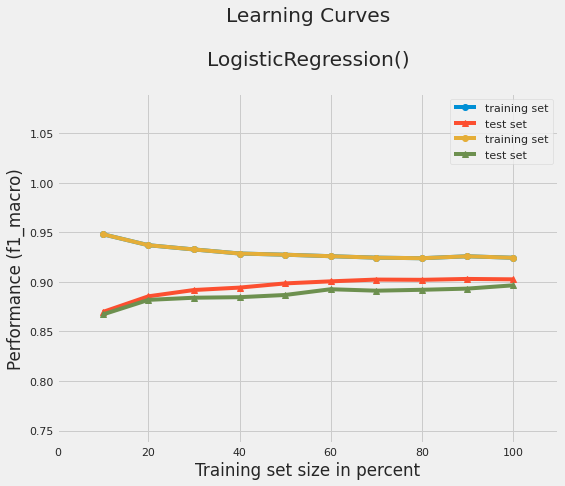

In [ ]:
# Define the classifier
clf = LogisticRegression()

# And call the plotting function for the train, dev and test data
plot_learning_curves(x_train_tfidf_vector, y_train, x_test_tfidf_vector, y_test, clf, scoring = 'f1_macro')
plot_learning_curves(x_train_tfidf_vector, y_train, x_dev_tfidf_vector, y_dev, clf, scoring = 'f1_macro')

***Learning curves for train, development and test dataset for the Naive Bayes classifier. On the x-axis, we display the increasingly more training data percentage. On the y-axis, we display the f1-macro score for each subset.***


([0.9248303934871099,
  0.9012182203389831,
  0.8919228397780322,
  0.8869910625620656,
  0.8817705299941759,
  0.8807404142794182,
  0.8795526673719208,
  0.8779923290570031,
  0.8783562923184683,
  0.8766711494343802],
 [0.8508997429305913,
  0.8662217985382904,
  0.8658035996210925,
  0.8638378720709309,
  0.8650190114068441,
  0.8701421800947868,
  0.8697027197975964,
  0.8679962013295347,
  0.8684376976597089,
  0.867745004757374])

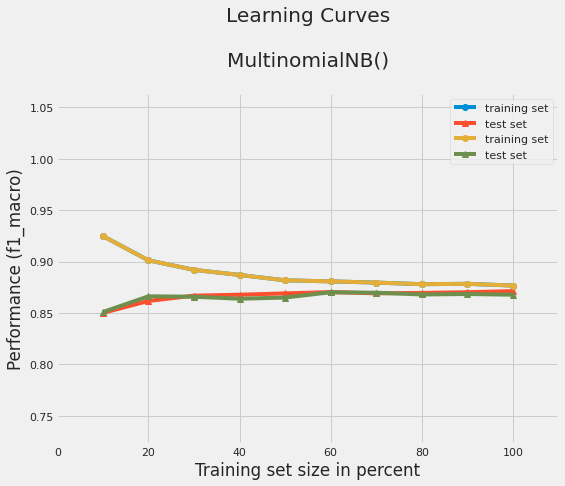

In [ ]:
# define the classifier
clf = MultinomialNB()

# and call the plotting function for the train, dev and test data
plot_learning_curves(x_train_tfidf_vector, y_train, x_test_tfidf_vector, y_test, clf, scoring = 'f1_macro')
plot_learning_curves(x_train_tfidf_vector, y_train, x_dev_tfidf_vector, y_dev, clf, scoring = 'f1_macro')

***Learning Curves - Logistic Regression (typical LC on the train dataset with a holdout of the validation set).***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


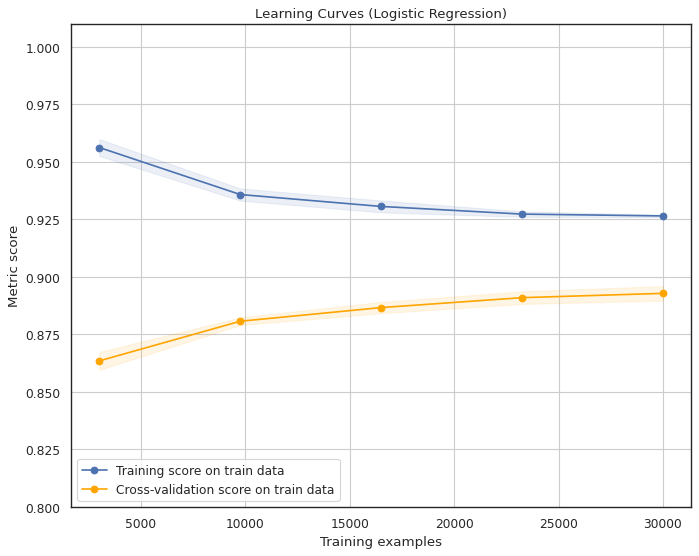

In [ ]:
# define the train, dev and test data, as we have many options...
# i.e. boolean vector, tf-idf vector (feature extraction), truncated svd vector (dimensionality reduction), best tf-idf vector (feature selection)
x_train, y_train = x_train_tfidf_vector, y_train
x_dev, y_dev = x_dev_tfidf_vector, y_dev
x_test, y_test = x_test_tfidf_vector, y_test

title = "Learning Curves (Logistic Regression)"   # define the plot's title

# Use cross validation with 5 splits, 20% test subset size each time
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LogisticRegression() # define the classifier

# and plot!
plot_learning_curve(estimator, title, x_train, y_train, (0.8, 1.01), cv=cv, n_jobs=-1)
plt.show()


***Learning Curves - Naive Bayes (typical LC on the train dataset with a holdout of the validation set)***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


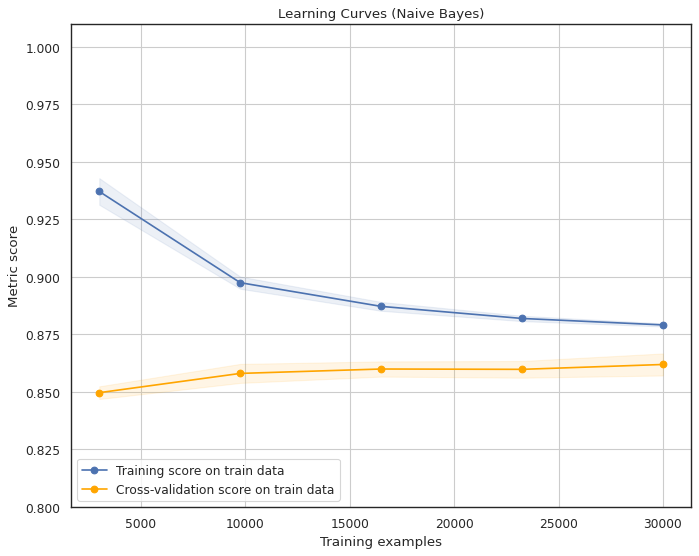

In [ ]:
# same procedure is followed for the Naive Bayes classifier
x_train, y_train = x_train_tfidf_vector, y_train
x_dev, y_dev = x_dev_tfidf_vector, y_dev
x_test, y_test = x_test_tfidf_vector, y_test

# Use cross validation with 5 splits, 20% test subset size each time
title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = MultinomialNB()
plot_learning_curve(estimator, title, x_train, y_train, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)
plt.show()

***Learning Curves - KNN (typical LC on the train dataset with a holdout of the validation set)***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


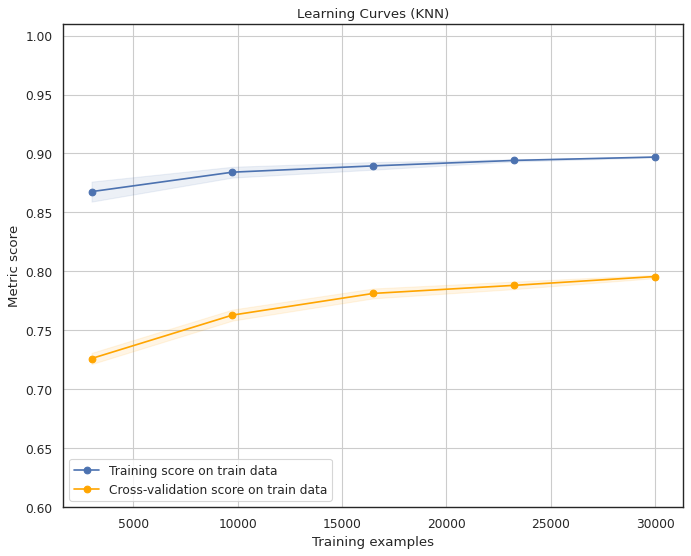

In [ ]:
# same procedure is also followed for the KNN classifier
x_train, y_train = x_train_tfidf_vector, y_train
x_dev, y_dev = x_dev_tfidf_vector, y_dev
x_test, y_test = x_test_tfidf_vector, y_test

title = "Learning Curves (KNN)"
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier(n_neighbors=3)
plot_learning_curve(estimator, title, x_train, y_train, (0.6, 1.01), cv=cv, n_jobs=-1)
plt.show()

***Precision-Recall Curves***


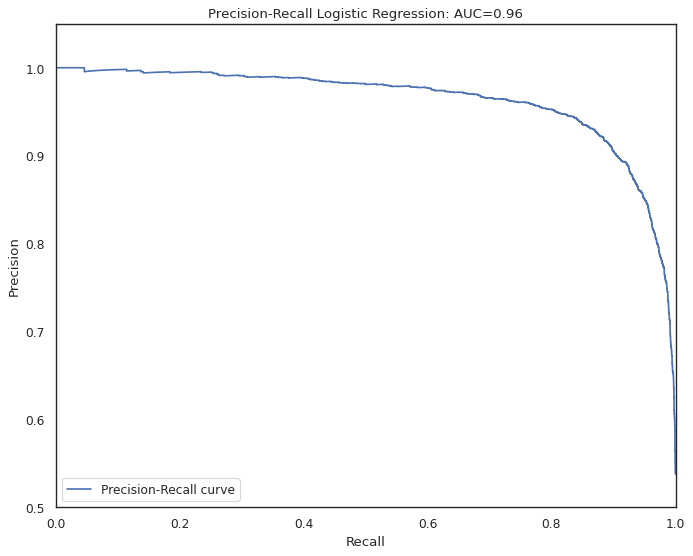

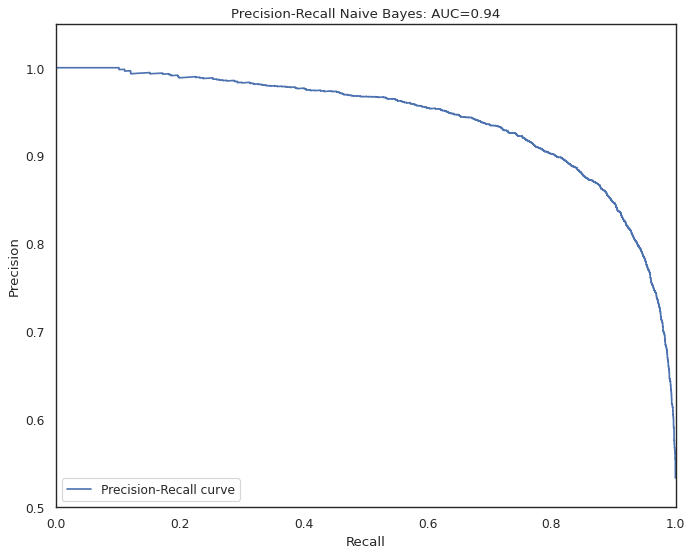

In [ ]:
# Precision-Recall curves

# Disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')
estimators = {'Logistic Regression':LogisticRegression(solver='liblinear'),
              'Naive Bayes':MultinomialNB()}

for (name,estimator) in estimators.items():
    
    model = estimator
    model.fit(x_train_tfidf_vector,y_train)
    # We use the probabilities because the precision_recall_curve function needs them
    pred = model.predict_proba(x_test_tfidf_vector)
    # model.predict() returns outputs of 0 or 1
    # model.predict_proba() returns an array: [P(x=0), P(x=1)]

    precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
    area = auc(recall, precision)

    plt.figure(figsize=(10, 8), dpi=80)
    ax = plt.axes()
    ax.set(facecolor = "white")
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall %s: AUC=%0.2f' % (name,area))
    plt.legend(loc="lower left")
    plt.show()

***Pipeline and Grid search***

In [ ]:
# build a pipeline in order to perform grid search for the Logistic Regression classifier
lr_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression())])

In [ ]:
# Better connect with local runtime. See instructions here
# https://research.google.com/colaboratory/local-runtimes.html
# Starting Jupyter inside a virtual env like anaconda is highly recommended
grid_params = {
  'lr__solver': ['liblinear'],
  'lr__C': np.linspace(0.1, 1, 10),
  'lr__max_iter': [50, 100, 200],
  'tfidf_vectorizer__min_df': np.linspace(0.01, 0.1, 5),
  'tfidf_vectorizer__ngram_range': [(1,1),(1,2)],  
  'tfidf_vectorizer__sublinear_tf': [True,False],
}

#default cv :  StratifiedKFold 
#default refit=True
clf = GridSearchCV(lr_pipeline, grid_params,scoring='f1',cv=3, n_jobs=-1)
start_time = time.time()
clf.fit(x_train_instances, y_train)
print("GridSearchCV took: {} seconds \n".format(time.time() - start_time))

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

KeyboardInterrupt: ignored